# Preventing stuck particles


In [another notebook](https://docs.oceanparcels.org/en/latest/examples/documentation_stuck_particles.html), we have shown how particles may end up getting stuck on land, especially in A gridded velocity fields. Here we show how you can work around this problem and how large the effects of the solutions on the trajectories are.

Common solutions are:

1. [Delete the particles](#1.-Particle-deletion)
2. [Displace the particles when they are within a certain distance of the coast.](#2.-Displacement)
3. [Implement free-slip or partial-slip boundary conditions](#3.-Slip-boundary-conditions)

In the first two of these solutions, kernels are used to modify the trajectories near the coast. The kernels all consist of two parts:

1. Flag particles whose trajectory should be modified
2. Modify the trajectory accordingly

In the third solution, the interpolation method is changed; this has to be done when creating the `FieldSet`.

This notebook is mainly focused on comparing the different modifications to the trajectory. The flagging of particles is also very relevant however and further discussion on this is encouraged. Some options shown here are:

1. Flag particles within a specific distance to the shore
2. Flag particles in any gridcell that has a shore edge

As argued in the [previous notebook](https://docs.oceanparcels.org/en/latest/examples/documentation_stuck_particles.html), it is important to accurately plot the grid discretization, in order to understand the motion of particles near the boundary. The velocity fields can best be depicted using points or arrows that define the velocity at a single position. Four of these nodes then form gridcells that can be shown using tiles, for example with `matplotlib.pyplot.pcolormesh`.


In [1]:
from copy import copy
from datetime import timedelta as delta

import cmocean
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from netCDF4 import Dataset
from scipy import interpolate

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    Geographic,
    GeographicPolar,
    JITParticle,
    ParticleSet,
    ScipyParticle,
    Variable,
)

## 1. Particle deletion

The simplest way to avoid trajectories that interact with the coastline is to remove them entirely. To do this, all `Particle` objects have a delete function that can be invoked in a kernel using `particle.delete()`


## 2. Displacement

A simple concept to avoid particles moving onto shore is displacing them towards the ocean as they get close to shore. This is for example done in [Kaandorp _et al._ (2020)](https://pubs.acs.org/doi/10.1021/acs.est.0c01984) and [Delandmeter and van Sebille (2018)](https://gmd.copernicus.org/articles/12/3571/2019/). To do so, a particle must be 'aware' of where the shore is and displaced accordingly. In Parcels, we can do this by adding a 'displacement' `Field` to the `Fieldset`, which contains vectors pointing away from shore.

**Step 1:** Import a velocity field - the A gridded SMOC product


In [2]:
file_path = "SMOC_20190704_R20190705.nc"
model = xr.open_dataset(file_path)

In [3]:
# define meshgrid coordinates to plot velocity field with matplotlib pcolormesh
latmin = 1595
latmax = 1612
lonmin = 2235
lonmax = 2260

# Velocity nodes
lon_vals, lat_vals = np.meshgrid(model["longitude"], model["latitude"])
lons_plot = lon_vals[latmin:latmax, lonmin:lonmax]
lats_plot = lat_vals[latmin:latmax, lonmin:lonmax]

dlon = 1 / 12
dlat = 1 / 12

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = model["longitude"][:-1] + np.diff(model["longitude"]) / 2
y = model["latitude"][:-1] + np.diff(model["latitude"]) / 2
lon_centers, lat_centers = np.meshgrid(x, y)

color_land = copy(plt.get_cmap("Reds"))(0)
color_ocean = copy(plt.get_cmap("Reds"))(128)

**Step 2:** Make a landmask where `land = 1` and `ocean = 0`.


In [4]:
def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables["uo"][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype("int")

    return landmask

In [5]:
landmask = make_landmask(file_path)

In [6]:
# Interpolate the landmask to the cell centers
# only cells with 4 neighbouring land points will be land
fl = interpolate.RectBivariateSpline(
    model["latitude"], model["longitude"], landmask, kx=1, ky=1
)

l_centers = fl(lat_centers[:, 0], lon_centers[0, :])

# land when interpolated value == 1
lmask = np.ma.masked_values(l_centers, 1)

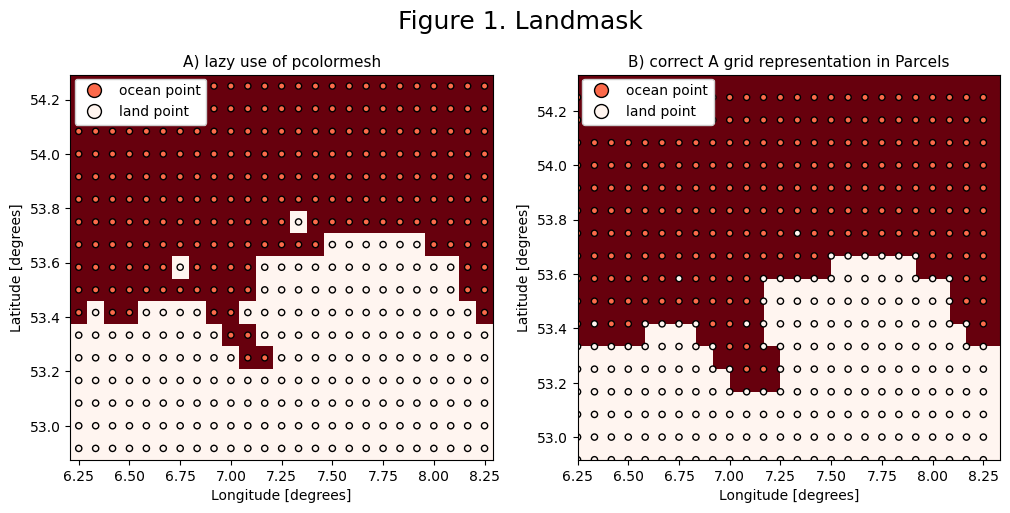

In [7]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Figure 1. Landmask", fontsize=18, y=1.01)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title("A) lazy use of pcolormesh", fontsize=11)
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

land0 = ax0.pcolormesh(
    lons_plot,
    lats_plot,
    landmask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
    shading="auto",
)
ax0.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)

custom_lines = [
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax0.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("B) correct A grid representation in Parcels", fontsize=11)
ax1.set_ylabel("Latitude [degrees]")
ax1.set_xlabel("Longitude [degrees]")

land1 = ax1.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax1.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)

ax1.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
);

Figure 1 shows why it is important to be precise when visualizing the model land and ocean. Parcels trajectories should not cross the land boundary between two land nodes as seen in 1B.


**Step 3:**  Detect the coast

We can detect the edges between land and ocean nodes by computing the Laplacian with the 4 nearest neighbors `[i+1,j]`, `[i-1,j]`, `[i,j+1]` and `[i,j-1]`:

$$\nabla^2 \text{landmask} = \partial_{xx} \text{landmask} + \partial_{yy} \text{landmask},$$

and filtering the positive and negative values. This gives us the location of _coast_ nodes (ocean nodes next to land) and _shore_ nodes (land nodes next to the ocean).

Additionally, we can find the nodes that border the coast/shore diagonally by considering the 8 nearest neighbors, including `[i+1,j+1]`, `[i-1,j+1]`, `[i-1,j+1]` and `[i-1,j-1]`.


In [8]:
def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4 * landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype("int")

    return coastal


def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4 * landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype("int")

    return shore

In [9]:
def get_coastal_nodes_diagonal(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes where
    one of the 8 nearest nodes is land. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1, 1), axis=(0, 1)) + np.roll(
        landmask, (1, 1), axis=(0, 1)
    )
    mask_lap += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (1, -1), axis=(0, 1)
    )
    mask_lap -= 8 * landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype("int")

    return coastal


def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1, 1), axis=(0, 1)) + np.roll(
        landmask, (1, 1), axis=(0, 1)
    )
    mask_lap += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (1, -1), axis=(0, 1)
    )
    mask_lap -= 8 * landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype("int")

    return shore

In [10]:
coastal = get_coastal_nodes_diagonal(landmask)
shore = get_shore_nodes_diagonal(landmask)

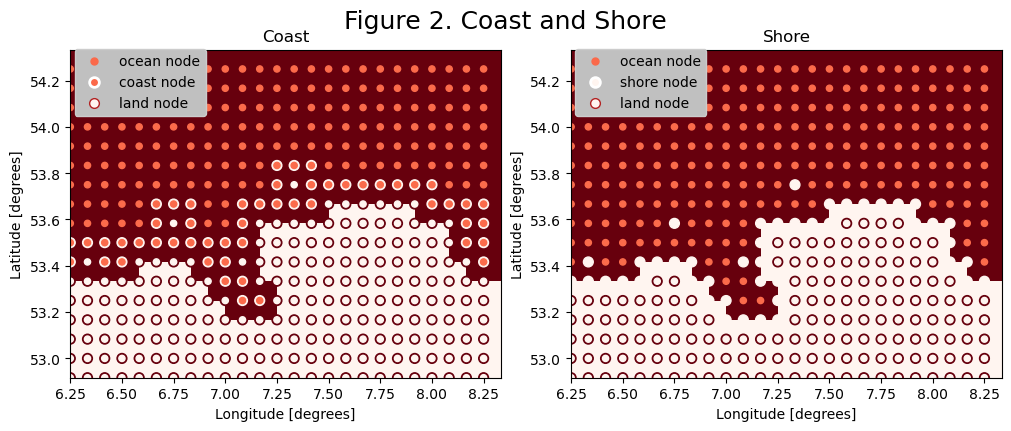

In [11]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
fig.suptitle("Figure 2. Coast and Shore", fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)


ax0 = fig.add_subplot(gs[0, 0])
land0 = ax0.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
coa = ax0.scatter(
    lons_plot, lats_plot, c=coastal[latmin:latmax, lonmin:lonmax], cmap="Reds_r", s=50
)
ax0.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
)

ax0.set_title("Coast")
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D([0], [0], c=color_ocean, marker="o", markersize=5, lw=0),
    Line2D(
        [0],
        [0],
        c=color_ocean,
        marker="o",
        markersize=7,
        markeredgecolor="w",
        markeredgewidth=2,
        lw=0,
    ),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="firebrick",
        lw=0,
    ),
]
ax0.legend(
    custom_lines,
    ["ocean node", "coast node", "land node"],
    bbox_to_anchor=(0.01, 0.9),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
    facecolor="silver",
)


ax1 = fig.add_subplot(gs[0, 1])
land1 = ax1.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
sho = ax1.scatter(
    lons_plot, lats_plot, c=shore[latmin:latmax, lonmin:lonmax], cmap="Reds_r", s=50
)
ax1.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=20,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
)

ax1.set_title("Shore")
ax1.set_ylabel("Latitude [degrees]")
ax1.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D([0], [0], c=color_ocean, marker="o", markersize=5, lw=0),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="w",
        markeredgewidth=2,
        lw=0,
    ),
    Line2D(
        [0],
        [0],
        c=color_land,
        marker="o",
        markersize=7,
        markeredgecolor="firebrick",
        lw=0,
    ),
]
ax1.legend(
    custom_lines,
    ["ocean node", "shore node", "land node"],
    bbox_to_anchor=(0.01, 0.9),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
    facecolor="silver",
);

**Step 4:** Assigning coastal velocities

For the displacement kernel we define a velocity field that pushes the particles back to the ocean. This velocity is a vector normal to the shore.

For the shore nodes directly next to the ocean, we can take the simple derivative of `landmask` and project the result to the `shore` array, this will capture the orientation of the velocity vectors.

For the shore nodes that only have a diagonal component, we need to take into account the diagonal nodes also and project the vectors only onto the inside corners that border the ocean diagonally.

Then to make the vectors unitary, we normalize them by their magnitude.


In [12]:
def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)

    # nodes bordering ocean directly and diagonally
    shore_d = get_shore_nodes_diagonal(landmask)
    # corner nodes that only border ocean diagonally
    shore_c = shore_d - shore

    # Simple derivative
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)

    Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    # Include y-component of diagonal neighbours
    Ly_c += np.roll(landmask, (-1, -1), axis=(0, 1)) + np.roll(
        landmask, (-1, 1), axis=(0, 1)
    )
    Ly_c += -np.roll(landmask, (1, -1), axis=(0, 1)) - np.roll(
        landmask, (1, 1), axis=(0, 1)
    )

    Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    # Include x-component of diagonal neighbours
    Lx_c += np.roll(landmask, (-1, -1), axis=(1, 0)) + np.roll(
        landmask, (-1, 1), axis=(1, 0)
    )
    Lx_c += -np.roll(landmask, (1, -1), axis=(1, 0)) - np.roll(
        landmask, (1, 1), axis=(1, 0)
    )

    v_x = -Lx * (shore)
    v_y = -Ly * (shore)

    v_x_c = -Lx_c * (shore_c)
    v_y_c = -Ly_c * (shore_c)

    v_x = v_x + v_x_c
    v_y = v_y + v_y_c

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x / magnitude
    v_y = v_y / magnitude

    return v_x, v_y

In [13]:
v_x, v_y = create_displacement_field(landmask)

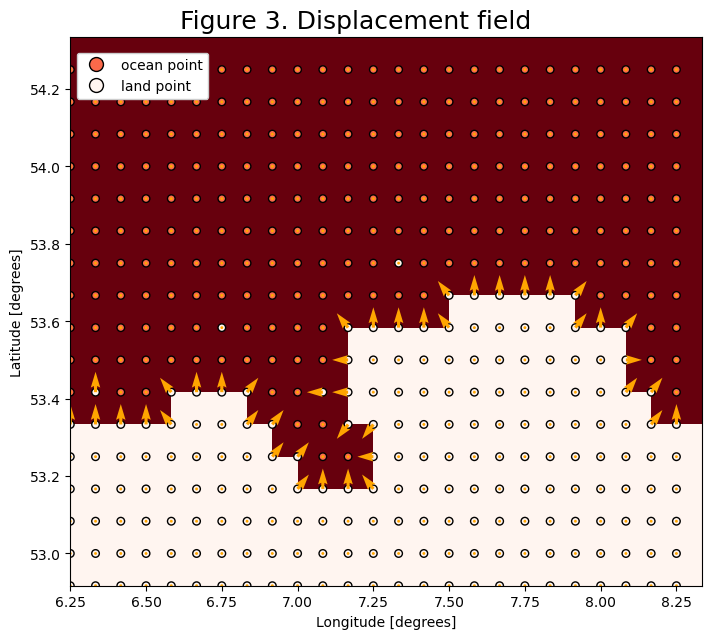

In [14]:
fig = plt.figure(figsize=(7, 6), constrained_layout=True)
fig.suptitle("Figure 3. Displacement field", fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land = ax0.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax0.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=30,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
quiv = ax0.quiver(
    lons_plot,
    lats_plot,
    v_x[latmin:latmax, lonmin:lonmax],
    v_y[latmin:latmax, lonmin:lonmax],
    color="orange",
    angles="xy",
    scale_units="xy",
    scale=19,
    width=0.005,
)

ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

custom_lines = [
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax0.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.93),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
);

**Step 5:** Calculate the distance to the shore

In this tutorial, we will only displace particles that are within some distance (smaller than the grid size) to the shore.

For this we map the distance of the coastal nodes to the shore: Coastal nodes directly neighbouring the shore are $1dx$ away. Diagonal neighbors are $\sqrt{2}dx$ away. The particles can then sample this field and will only be displaced when closer than a threshold value. This gives a crude estimate of the distance.


In [15]:
def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimension. This is a crude approxsimation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask)  # direct neighbours
    dist = ci * dx  # 1 dx away

    ci_d = get_coastal_nodes_diagonal(landmask)  # diagonal neighbours
    dist_d = (ci_d - ci) * np.sqrt(2 * dx**2)  # sqrt(2) dx away

    return dist + dist_d

In [16]:
d_2_s = distance_to_shore(landmask)

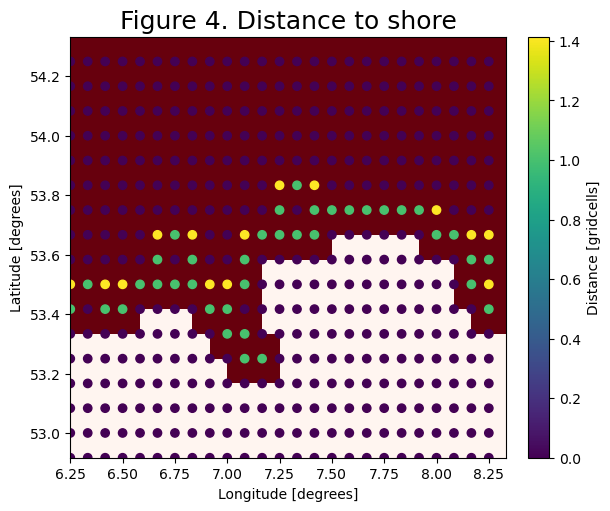

In [17]:
fig = plt.figure(figsize=(6, 5), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title("Figure 4. Distance to shore", fontsize=18)
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")

land = ax0.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
d2s = ax0.scatter(lons_plot, lats_plot, c=d_2_s[latmin:latmax, lonmin:lonmax])

plt.colorbar(d2s, ax=ax0, label="Distance [gridcells]");

**Step 6:** Particle and Kernels

The distance to shore, used to flag whether a particle must be displaced, is stored in a particle `Variable` `d2s`. To visualize the displacement, the zonal and meridional displacements are stored in the variables `dU` and `dV`.

To write the displacement vector to the output before displacing the particle, the `set_displacement` kernel is invoked after the advection kernel. Then only in the next timestep are particles displaced by `displace`, before resuming the advection.


In [18]:
class DisplacementParticle(JITParticle):
    dU = Variable("dU")
    dV = Variable("dV")
    d2s = Variable("d2s", initial=1e3)


def set_displacement(particle, fieldset, time):
    particle.d2s = fieldset.distance2shore[
        time, particle.depth, particle.lat, particle.lon
    ]
    if particle.d2s < 0.5:
        dispUab = fieldset.dispU[time, particle.depth, particle.lat, particle.lon]
        dispVab = fieldset.dispV[time, particle.depth, particle.lat, particle.lon]
        particle.dU = dispUab
        particle.dV = dispVab
    else:
        particle.dU = 0.0
        particle.dV = 0.0


def displace(particle, fieldset, time):
    if particle.d2s < 0.5:
        particle.lon += particle.dU * particle.dt
        particle.lat += particle.dV * particle.dt

**Step 7:** Simulation

Let us first do a simulation with the default AdvectionRK4 kernel for comparison later


In [19]:
SMOCfile = "SMOC_201907*.nc"
filenames = {"U": SMOCfile, "V": SMOCfile}

variables = {"U": "uo", "V": "vo"}

dims = {"lon": "longitude", "lat": "latitude", "depth": "depth", "time": "time"}
dimensions = {"U": dims, "V": dims}

indices = {
    "lon": range(lonmin, lonmax),
    "lat": range(latmin, latmax),
}  # to load only a small part of the domain

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices=indices)

And we use the following set of 9 particles


In [20]:
npart = 9  # number of particles to be released
lon = np.linspace(7, 7.2, int(np.sqrt(npart)), dtype=np.float32)
lat = np.linspace(53.45, 53.65, int(np.sqrt(npart)), dtype=np.float32)
lons, lats = np.meshgrid(lon, lat)
time = np.zeros(lons.size)

runtime = delta(hours=100)
dt = delta(minutes=10)

In [21]:
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

kernels = AdvectionRK4

output_file = pset.ParticleFile(name="SMOC.zarr", outputdt=delta(hours=1))

pset.execute(kernels, runtime=runtime, dt=dt, output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib196bc806b58b615c3cb53057de6a5c6a_0.so


Now let's add the Fields we created above to the FieldSet and do a simulation to test the displacement of the particles as they approach the shore.


In [22]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices=indices)
u_displacement = v_x
v_displacement = v_y
fieldset.add_field(
    Field(
        "dispU",
        data=u_displacement[latmin:latmax, lonmin:lonmax],
        lon=fieldset.U.grid.lon,
        lat=fieldset.U.grid.lat,
        mesh="spherical",
    )
)
fieldset.add_field(
    Field(
        "dispV",
        data=v_displacement[latmin:latmax, lonmin:lonmax],
        lon=fieldset.U.grid.lon,
        lat=fieldset.U.grid.lat,
        mesh="spherical",
    )
)
fieldset.dispU.units = GeographicPolar()
fieldset.dispV.units = Geographic()

In [23]:
fieldset.add_field(
    Field(
        "landmask",
        landmask[latmin:latmax, lonmin:lonmax],
        lon=fieldset.U.grid.lon,
        lat=fieldset.U.grid.lat,
        mesh="spherical",
    )
)
fieldset.add_field(
    Field(
        "distance2shore",
        d_2_s[latmin:latmax, lonmin:lonmax],
        lon=fieldset.U.grid.lon,
        lat=fieldset.U.grid.lat,
        mesh="spherical",
    )
)

In [24]:
pset = ParticleSet(
    fieldset=fieldset, pclass=DisplacementParticle, lon=lons, lat=lats, time=time
)

kernels = [
    pset.Kernel(displace),
    pset.Kernel(AdvectionRK4),
    pset.Kernel(set_displacement),
]

output_file = pset.ParticleFile(name="SMOC-disp.zarr", outputdt=delta(hours=1))

pset.execute(kernels, runtime=runtime, dt=dt, output_file=output_file)

INFO: Compiled ArrayDisplacementParticledisplaceAdvectionRK4set_displacement ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib217e290cc6bf808040d408b589006c90_0.so


**Step 10:** Output

To visualize the effect of the displacement, the particle trajectory output can be compared to the simulation without the displacement kernel.


In [25]:
ds_SMOC = xr.open_zarr("SMOC.zarr")
ds_SMOC_disp = xr.open_zarr("SMOC-disp.zarr")

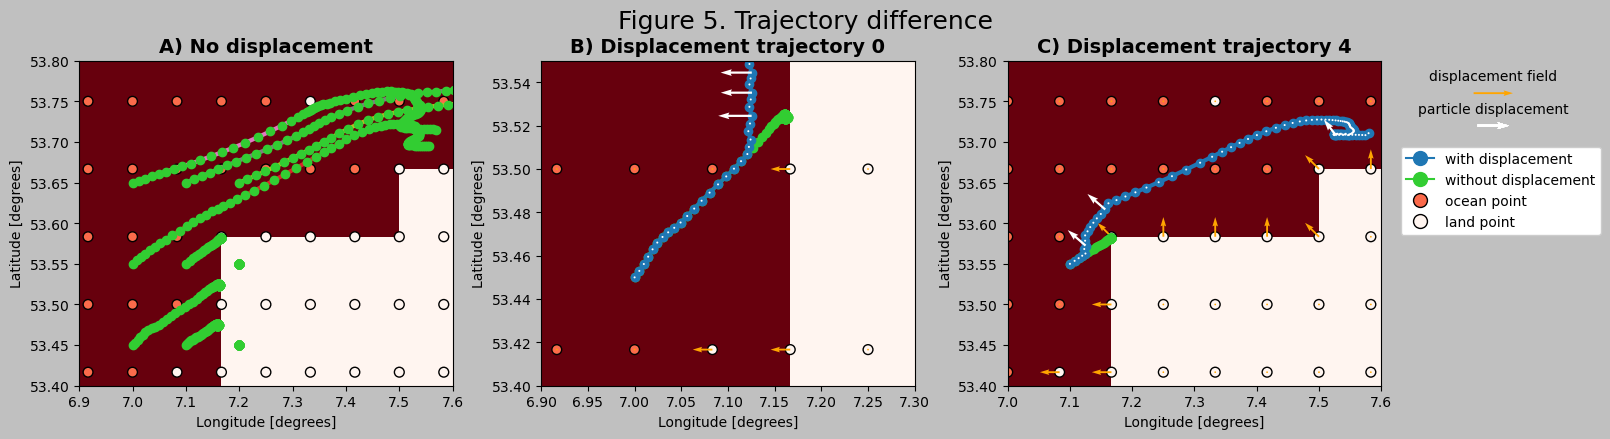

In [26]:
fig = plt.figure(figsize=(16, 4), facecolor="silver", constrained_layout=True)
fig.suptitle("Figure 5. Trajectory difference", fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[1, 1, 1, 0.3], figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")
ax0.set_title("A) No displacement", fontsize=14, fontweight="bold")
ax0.set_xlim(6.9, 7.6)
ax0.set_ylim(53.4, 53.8)

land = ax0.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax0.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=50,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax0.plot(ds_SMOC["lon"].T, ds_SMOC["lat"].T, linewidth=3, zorder=1)
ax0.scatter(ds_SMOC["lon"], ds_SMOC["lat"], color="limegreen", zorder=2)

n_p0 = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_ylabel("Latitude [degrees]")
ax1.set_xlabel("Longitude [degrees]")
ax1.set_title("B) Displacement trajectory " + str(n_p0), fontsize=14, fontweight="bold")
ax1.set_xlim(6.9, 7.3)
ax1.set_ylim(53.4, 53.55)

land = ax1.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax1.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=50,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
quiv = ax1.quiver(
    lons_plot,
    lats_plot,
    v_x[latmin:latmax, lonmin:lonmax],
    v_y[latmin:latmax, lonmin:lonmax],
    color="orange",
    scale=19,
    width=0.005,
)
ax1.plot(
    ds_SMOC_disp["lon"][n_p0].T, ds_SMOC_disp["lat"][n_p0].T, linewidth=3, zorder=1
)
ax1.scatter(ds_SMOC["lon"][n_p0], ds_SMOC["lat"][n_p0], color="limegreen", zorder=2)
ax1.scatter(ds_SMOC_disp["lon"][n_p0], ds_SMOC_disp["lat"][n_p0], color="C00", zorder=2)
ax1.quiver(
    ds_SMOC_disp["lon"][n_p0],
    ds_SMOC_disp["lat"][n_p0],
    ds_SMOC_disp["dU"][n_p0],
    ds_SMOC_disp["dV"][n_p0],
    color="w",
    angles="xy",
    scale_units="xy",
    scale=2e-4,
    zorder=3,
)

n_p1 = 4
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_ylabel("Latitude [degrees]")
ax2.set_xlabel("Longitude [degrees]")
ax2.set_title("C) Displacement trajectory " + str(n_p1), fontsize=14, fontweight="bold")
ax2.set_xlim(7.0, 7.6)
ax2.set_ylim(53.4, 53.8)

land = ax2.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax2.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=50,
    cmap="Reds_r",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
q1 = ax2.quiver(
    lons_plot,
    lats_plot,
    v_x[latmin:latmax, lonmin:lonmax],
    v_y[latmin:latmax, lonmin:lonmax],
    color="orange",
    scale=19,
    width=0.005,
)
ax2.plot(
    ds_SMOC_disp["lon"][n_p1].T, ds_SMOC_disp["lat"][n_p1].T, linewidth=3, zorder=1
)
ax2.scatter(ds_SMOC["lon"][n_p1], ds_SMOC["lat"][n_p1], color="limegreen", zorder=2)
ax2.scatter(ds_SMOC_disp["lon"][n_p1], ds_SMOC_disp["lat"][n_p1], zorder=2)
q2 = ax2.quiver(
    ds_SMOC_disp["lon"][n_p1],
    ds_SMOC_disp["lat"][n_p1],
    ds_SMOC_disp["dU"][n_p1],
    ds_SMOC_disp["dV"][n_p1],
    color="w",
    angles="xy",
    scale_units="xy",
    scale=2e-4,
    zorder=3,
)

ax3 = fig.add_subplot(gs[0, 3])
ax3.axis("off")
custom_lines = [
    Line2D([0], [0], c="tab:blue", marker="o", markersize=10),
    Line2D([0], [0], c="limegreen", marker="o", markersize=10),
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax3.legend(
    custom_lines,
    ["with displacement", "without displacement", "ocean point", "land point"],
    bbox_to_anchor=(0.0, 0.6),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
)

ax2.quiverkey(q1, 1.3, 0.9, 2, "displacement field", coordinates="axes")
ax2.quiverkey(q2, 1.3, 0.8, 1e-5, "particle displacement", coordinates="axes")
plt.show()

### Conclusion

Figure 5 shows how particles are prevented from approaching the coast in a 5 day simulation. Note that to show each computation, the integration timestep (`dt`) is equal to the output timestep (`outputdt`): 1 hour. This is relatively large, and causes the displacement to be on the order of 4 km and be relatively infrequent. It is advised to use smaller `dt` in real simulations.


In [27]:
d2s_cmap = copy(plt.get_cmap("cmo.deep_r"))
d2s_cmap.set_over("gold")

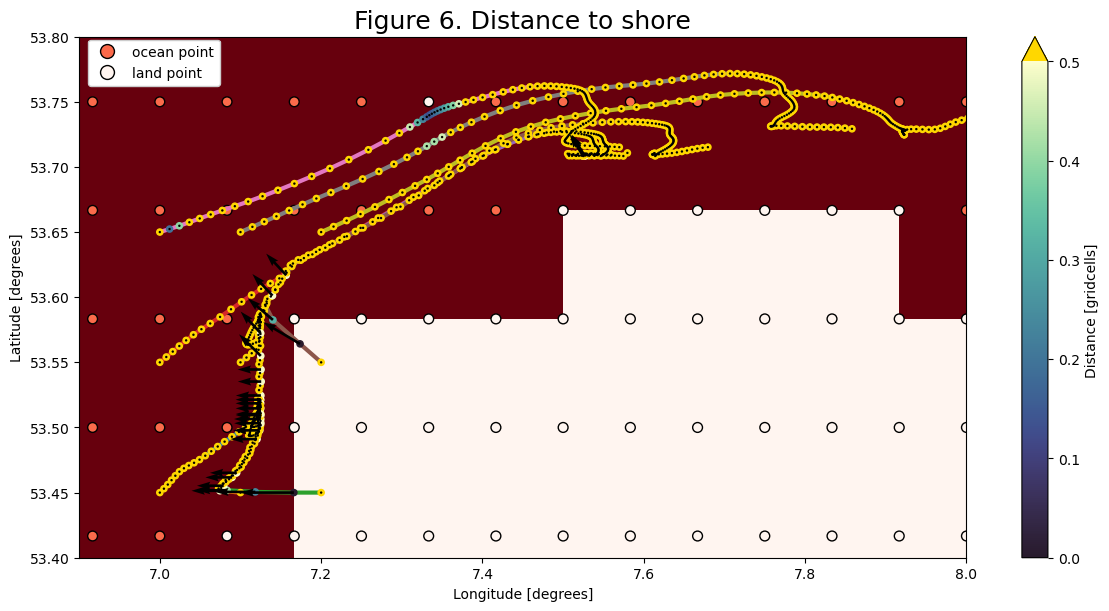

In [28]:
fig = plt.figure(figsize=(11, 6), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title("Figure 6. Distance to shore", fontsize=18)
land = ax0.pcolormesh(
    lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
    lmask.mask[latmin:latmax, lonmin:lonmax],
    cmap="Reds_r",
)
ax0.scatter(
    lons_plot,
    lats_plot,
    c=landmask[latmin:latmax, lonmin:lonmax],
    s=50,
    cmap="Reds_r",
    edgecolor="k",
    vmin=-0.05,
    vmax=0.05,
)
ax0.plot(ds_SMOC_disp["lon"].T, ds_SMOC_disp["lat"].T, linewidth=3, zorder=1)
d2s = ax0.scatter(
    ds_SMOC_disp["lon"],
    ds_SMOC_disp["lat"],
    c=ds_SMOC_disp["d2s"],
    cmap=d2s_cmap,
    s=20,
    vmax=0.5,
    zorder=2,
)
q2 = ax0.quiver(
    ds_SMOC_disp["lon"],
    ds_SMOC_disp["lat"],
    ds_SMOC_disp["dU"],
    ds_SMOC_disp["dV"],
    color="k",
    angles="xy",
    scale_units="xy",
    scale=2.3e-4,
    width=0.003,
    zorder=3,
)

ax0.set_xlim(6.9, 8)
ax0.set_ylim(53.4, 53.8)
ax0.set_ylabel("Latitude [degrees]")
ax0.set_xlabel("Longitude [degrees]")
plt.colorbar(d2s, ax=ax0, label="Distance [gridcells]", extend="max")

color_land = copy(plt.get_cmap("Reds"))(0)
color_ocean = copy(plt.get_cmap("Reds"))(128)

custom_lines = [
    Line2D(
        [0], [0], c=color_ocean, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
    Line2D(
        [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
    ),
]
ax0.legend(
    custom_lines,
    ["ocean point", "land point"],
    bbox_to_anchor=(0.01, 0.95),
    loc="center left",
    borderaxespad=0.0,
    framealpha=1,
);

## 3. Slip boundary conditions

The reason trajectories do not neatly follow the coast in A grid velocity fields is that the lack of staggering causes both velocity components to go to zero in the same way towards the cell edge. This no-slip condition can be turned into a free-slip or partial-slip condition by separately considering the cross-shore and along-shore velocity components as in [a staggered C-grid](https://docs.oceanparcels.org/en/latest/examples/documentation_stuck_particles.html#2.-C-grids). Each interpolation of the velocity field must then be corrected with a factor depending on the direction of the boundary.

These boundary conditions have been implemented in Parcels as `interp_method=partialslip` and `interp_method=freeslip`, which we will show in the plot below


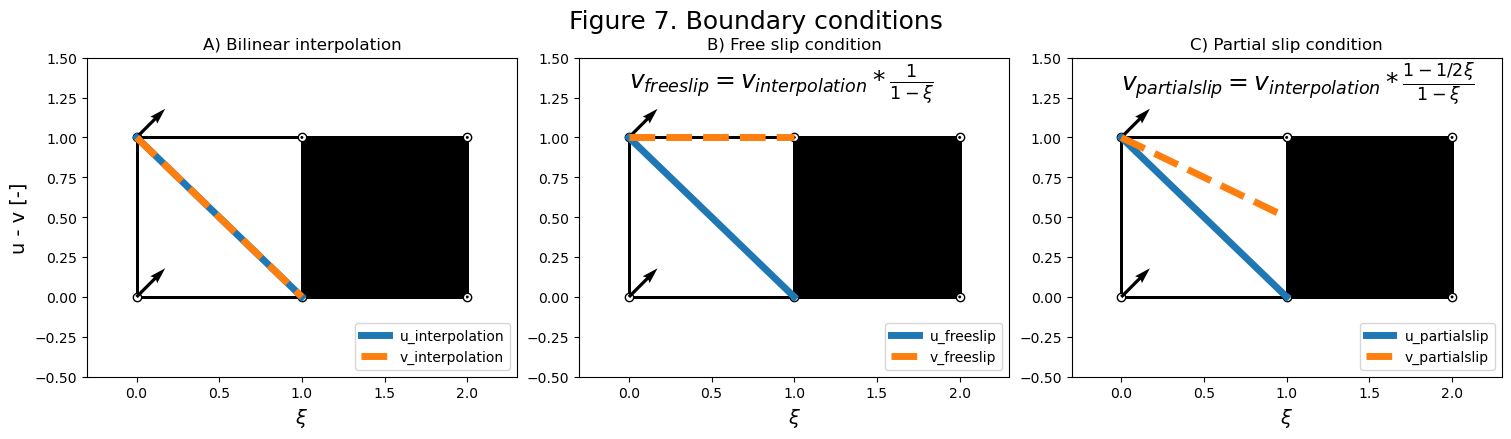

In [29]:
cells_x = np.array([[0, 0], [1, 1], [2, 2]])
cells_y = np.array([[0, 1], [0, 1], [0, 1]])
U0 = 1
V0 = 1
U = np.array([U0, U0, 0, 0, 0, 0])
V = np.array([V0, V0, 0, 0, 0, 0])
xsi = np.linspace(0.001, 0.999)

u_interp = U0 * (1 - xsi)
v_interp = V0 * (1 - xsi)

u_freeslip = u_interp
v_freeslip = v_interp / (1 - xsi)

u_partslip = u_interp
v_partslip = v_interp * (1 - 0.5 * xsi) / (1 - xsi)


fig = plt.figure(figsize=(15, 4), constrained_layout=True)
fig.suptitle("Figure 7. Boundary conditions", fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])

ax0.pcolormesh(cells_x, cells_y, np.array([[0], [1]]), cmap="Greys", edgecolor="k")
ax0.scatter(cells_x, cells_y, c="w", edgecolor="k")
ax0.quiver(cells_x, cells_y, U, V, scale=15)

ax0.plot(xsi, u_interp, linewidth=5, label="u_interpolation")
ax0.plot(xsi, v_interp, linestyle="dashed", linewidth=5, label="v_interpolation")
ax0.set_xlim(-0.3, 2.3)
ax0.set_ylim(-0.5, 1.5)
ax0.set_ylabel("u - v [-]", fontsize=14)
ax0.set_xlabel(r"$\xi$", fontsize=14)
ax0.set_title("A) Bilinear interpolation")
ax0.legend(loc="lower right")


ax1 = fig.add_subplot(gs[0, 1])

ax1.pcolormesh(cells_x, cells_y, np.array([[0], [1]]), cmap="Greys", edgecolor="k")
ax1.scatter(cells_x, cells_y, c="w", edgecolor="k")
ax1.quiver(cells_x, cells_y, U, V, scale=15)

ax1.plot(xsi, u_freeslip, linewidth=5, label="u_freeslip")
ax1.plot(xsi, v_freeslip, linestyle="dashed", linewidth=5, label="v_freeslip")
ax1.set_xlim(-0.3, 2.3)
ax1.set_ylim(-0.5, 1.5)
ax1.set_xlabel(r"$\xi$", fontsize=14)
ax1.text(0.0, 1.3, r"$v_{freeslip} = v_{interpolation}*\frac{1}{1-\xi}$", fontsize=18)
ax1.set_title("B) Free slip condition")
ax1.legend(loc="lower right")

ax2 = fig.add_subplot(gs[0, 2])

ax2.pcolormesh(cells_x, cells_y, np.array([[0], [1]]), cmap="Greys", edgecolor="k")
ax2.scatter(cells_x, cells_y, c="w", edgecolor="k")
ax2.quiver(cells_x, cells_y, U, V, scale=15)

ax2.plot(xsi, u_partslip, linewidth=5, label="u_partialslip")
ax2.plot(xsi, v_partslip, linestyle="dashed", linewidth=5, label="v_partialslip")
ax2.set_xlim(-0.3, 2.3)
ax2.set_ylim(-0.5, 1.5)
ax2.set_xlabel(r"$\xi$", fontsize=14)
ax2.text(
    0.0,
    1.3,
    r"$v_{partialslip} = v_{interpolation}*\frac{1-1/2\xi}{1-\xi}$",
    fontsize=18,
)
ax2.set_title("C) Partial slip condition")
ax2.legend(loc="lower right");

Consider a grid cell with a solid boundary to the right and vectors $(U0, V0)$ = $(1, 1)$ on the left-hand nodes, as in **figure 7**. Parcels bilinear interpolation will interpolate in the $x$ and $y$ directions. This cell is invariant in the $y$-direction, we will only consider the effect in the direction normal to the boundary. In the x-direction, both u and v will be interpolated along $\xi$, the normalized $x$-coordinate within the cell. This is plotted with the blue and orange dashed lines in **subfigure 7A**.

A free slip boundary condition is defined with $\frac{\delta v}{\delta \xi}=0$. This means that the tangential velocity is constant in the direction normal to the boundary. This can be achieved in a kernel after interpolation by dividing by $(1-\xi)$. The resulting velocity profiles are shown in **subfigure 7B**.

A partial slip boundary condition is defined with a tangential velocity profile that decreases toward the boundary, but not to zero. This can be achieved by multiplying the interpolated velocity by $\frac{1-1/2\xi}{1-\xi}$. This is shown in **subfigure 7C**.


For each direction and boundary condition a different factor must be used (where $\xi$ and $\eta$ are the normalized x- and y-coordinates within the cell, respectively):

- Free slip

  1: $f_u = \frac{1}{\eta}$

  2: $f_u = \frac{1}{(1-\eta)}$

  4: $f_v = \frac{1}{\xi}$

  8: $f_v = \frac{1}{(1-\xi)}$

- Partial slip

  1: $f_u = \frac{1/2+1/2\eta}{\eta}$

  2: $f_u = \frac{1-1/2\eta}{1-\eta}$

  4: $f_v = \frac{1/2+1/2\xi}{\xi}$

  8: $f_v = \frac{1-1/2\xi}{1-\xi}$


We now simulate the three different boundary conditions by advecting the 9 particles from above in a time-evolving SMOC dataset from [CMEMS](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024).


In [30]:
SMOCfiles = "SMOC_201907*.nc"
filenames = {"U": SMOCfile, "V": SMOCfile}

variables = {"U": "uo", "V": "vo"}

dims = {"lon": "longitude", "lat": "latitude", "depth": "depth", "time": "time"}
dimensions = {"U": dims, "V": dims}

indices = {"lon": range(lonmin, lonmax), "lat": range(latmin, latmax)}

First up is the **partialslip interpolation** (note that we have to redefine the `FieldSet` because the `interp_method=partialslip` is set there)


In [31]:
fieldset = FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    indices=indices,
    interp_method={
        "U": "partialslip",
        "V": "partialslip",
    },  # Setting the interpolation for U and V
)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4)

output_file = pset.ParticleFile(name="SMOC_partialslip.zarr", outputdt=delta(hours=1))

pset.execute(kernels, runtime=runtime, dt=dt, output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libeb6fd0f453efb5da0fa9fa1daefc01c7_0.so


And then we also use the **freeslip** interpolation


In [32]:
fieldset = FieldSet.from_netcdf(
    filenames,
    variables,
    dimensions,
    indices=indices,
    interp_method={
        "U": "freeslip",
        "V": "freeslip",
    },  # Setting the interpolation for U and V
)
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4)

output_file = pset.ParticleFile(name="SMOC_freeslip.zarr", outputdt=delta(hours=1))

pset.execute(kernels, runtime=runtime, dt=dt, output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/libb3898ac0aaa9105204339090c7f79dcb_0.so


Now we can load and plot the three different `interpolation_methods`


In [33]:
ds_SMOC = xr.open_zarr("SMOC.zarr")
ds_SMOC_part = xr.open_zarr("SMOC_partialslip.zarr")
ds_SMOC_free = xr.open_zarr("SMOC_freeslip.zarr")

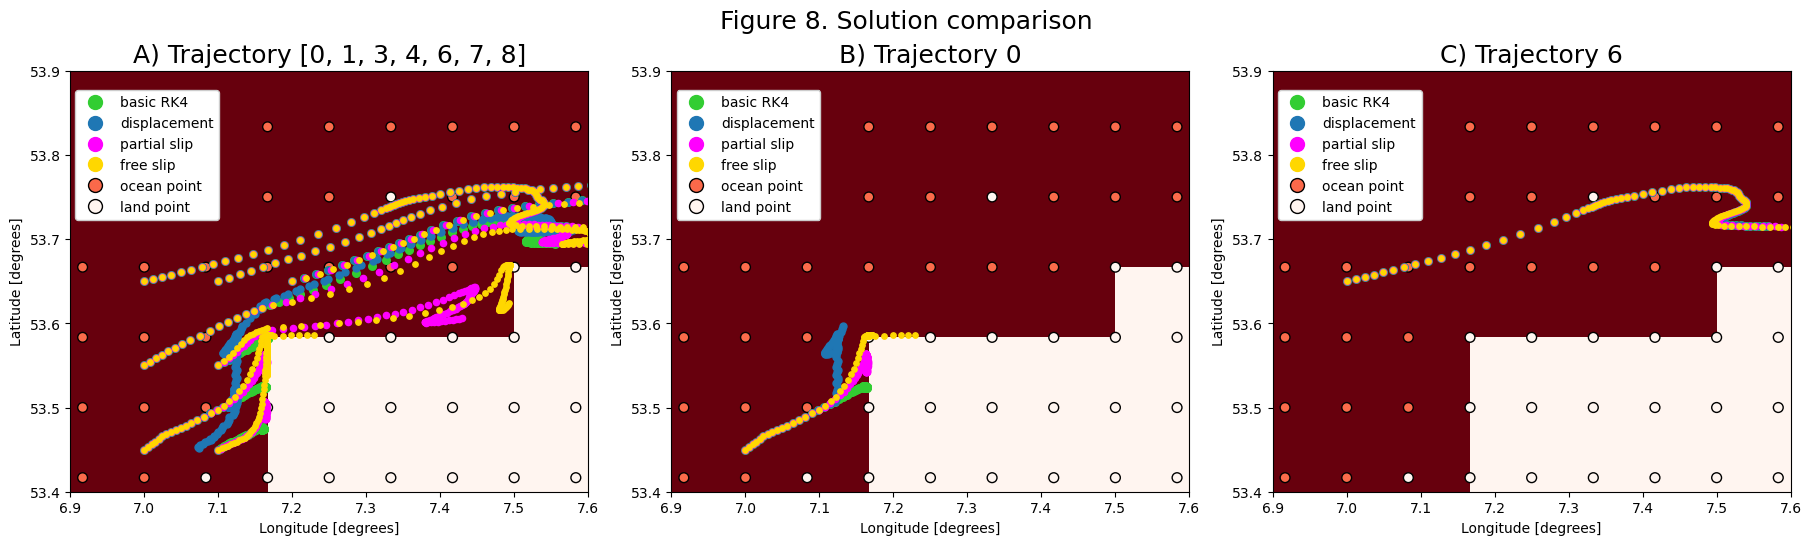

In [34]:
fig = plt.figure(figsize=(18, 5), constrained_layout=True)
fig.suptitle("Figure 8. Solution comparison", fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

n_p = [[0, 1, 3, 4, 6, 7, 8], 0, 6]

for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    ax.set_title(chr(i + 65) + ") Trajectory " + str(n_p[i]), fontsize=18)
    land = ax.pcolormesh(
        lon_vals[latmin : latmax + 1, lonmin : lonmax + 1],
        lat_vals[latmin : latmax + 1, lonmin : lonmax + 1],
        lmask.mask[latmin:latmax, lonmin:lonmax],
        cmap="Reds_r",
    )
    ax.scatter(
        lons_plot,
        lats_plot,
        c=landmask[latmin:latmax, lonmin:lonmax],
        s=50,
        cmap="Reds_r",
        vmin=-0.05,
        vmax=0.05,
        edgecolors="k",
    )

    ax.scatter(
        ds_SMOC["lon"][n_p[i]],
        ds_SMOC["lat"][n_p[i]],
        s=30,
        color="limegreen",
        zorder=2,
    )

    ax.scatter(
        ds_SMOC_disp["lon"][n_p[i]],
        ds_SMOC_disp["lat"][n_p[i]],
        s=25,
        color="tab:blue",
        zorder=2,
    )

    ax.scatter(
        ds_SMOC_part["lon"][n_p[i]],
        ds_SMOC_part["lat"][n_p[i]],
        s=20,
        color="magenta",
        zorder=2,
    )

    ax.scatter(
        ds_SMOC_free["lon"][n_p[i]],
        ds_SMOC_free["lat"][n_p[i]],
        s=15,
        color="gold",
        zorder=2,
    )

    ax.set_xlim(6.9, 7.6)
    ax.set_ylim(53.4, 53.9)
    ax.set_ylabel("Latitude [degrees]")
    ax.set_xlabel("Longitude [degrees]")

    color_land = copy(plt.get_cmap("Reds"))(0)
    color_ocean = copy(plt.get_cmap("Reds"))(128)

    custom_lines = [
        Line2D([0], [0], c="limegreen", marker="o", markersize=10, lw=0),
        Line2D([0], [0], c="tab:blue", marker="o", markersize=10, lw=0),
        Line2D([0], [0], c="magenta", marker="o", markersize=10, lw=0),
        Line2D([0], [0], c="gold", marker="o", markersize=10, lw=0),
        Line2D(
            [0],
            [0],
            c=color_ocean,
            marker="o",
            markersize=10,
            markeredgecolor="k",
            lw=0,
        ),
        Line2D(
            [0], [0], c=color_land, marker="o", markersize=10, markeredgecolor="k", lw=0
        ),
    ]
    ax.legend(
        custom_lines,
        [
            "basic RK4",
            "displacement",
            "partial slip",
            "free slip",
            "ocean point",
            "land point",
        ],
        bbox_to_anchor=(0.01, 0.8),
        loc="center left",
        borderaxespad=0.0,
        framealpha=1,
    )

**Figure 8** shows the influence of the different solutions on the particle trajectories near the shore. **Subfigure 8B** shows how the different solutions make trajectory 0 move along the shore and around the corner of the model geometry. **Subfigure 8C** shows how trajectories are unaffected by the different interpolation scheme as long as they do not cross a coastal gridcell.
